# Requirement 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from bidding_environment import SecondPriceAuction 
from clairvoyant_bidder import get_clairvoyant_truthful
from bidding_agent import MultiplicativePacingAgent,ucblike,gpucblike
from pricing_agent import GPUCBAgent
from pricing_environment import PricingEnvironment,get_expected_profit

## PRICING

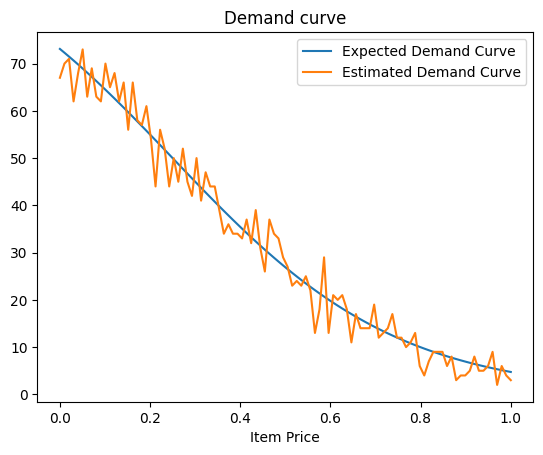

In [2]:
n_cust=100
norm_dem_curve=lambda p: 1-1/(1+np.exp(-4*(p)+1))
y=norm_dem_curve
prices=np.linspace(0,1,100)
estimated_demand_curve = np.random.binomial(n_cust, norm_dem_curve(prices))

plt.figure()
plt.title('Demand curve')
plt.plot(prices, n_cust*norm_dem_curve(prices), label='Expected Demand Curve')
plt.plot(prices, estimated_demand_curve, label='Estimated Demand Curve')
plt.xlabel('Item Price')
plt.legend()
plt.show()

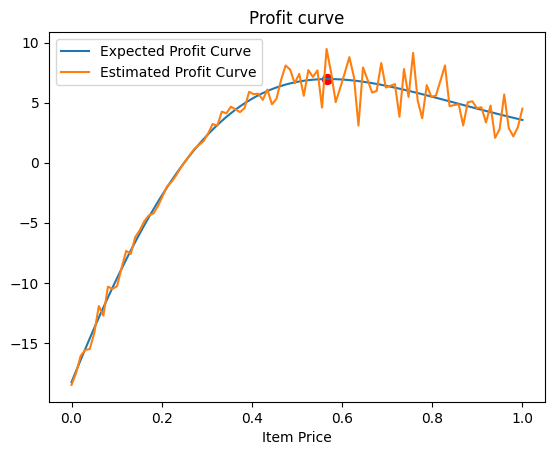

In [3]:
cost = 0.25

expected_profit_curve = n_cust*norm_dem_curve(prices)*(prices-cost)

estimated_profit_curve = np.random.binomial(100,norm_dem_curve(prices))*(prices-cost)

best_price_index = np.argmax(expected_profit_curve)
best_price = prices[best_price_index]

plt.figure()
plt.title('Profit curve')
plt.plot(prices, expected_profit_curve, label='Expected Profit Curve')
plt.plot(prices, estimated_profit_curve, label='Estimated Profit Curve')
plt.scatter(best_price, expected_profit_curve[best_price_index], color='red', s=50)
plt.xlabel('Item Price')
plt.legend()
plt.show()

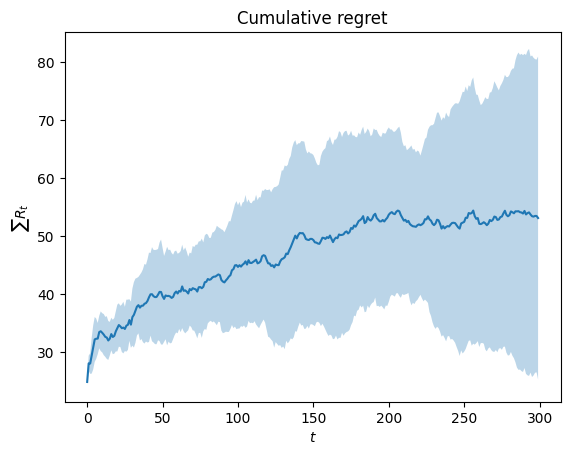

In [18]:
T=300
num_cust=100
all_pulls=[]
all_rewards=[]
all_regrets=[]
epochs=10

for _ in range(epochs):
    pulls=np.array([])
    rewards=np.array([])
    clair_reward=np.array([])
    env=PricingEnvironment(norm_dem_curve,cost)
    agent=GPUCBAgent(T)

    for t in range(T):
        p_t = agent.pull_arm()
        d_t, r_t = env.round(p_t, num_cust)
        agent.update(r_t/num_cust)
        rewards = np.append(rewards, r_t)
        pulls=np.append(pulls,p_t)
        dc,rc=env.round(best_price,num_cust)
        clair_reward = np.append(clair_reward, rc)
    cum_clair_reward=np.cumsum(clair_reward)
    cum_reward=np.cumsum(rewards)
    all_pulls.append(pulls)
    all_rewards.append(rewards)
    all_regrets.append(cum_clair_reward-cum_reward)


    
cum_clair_reward=np.cumsum(clair_reward)
cum_reward=np.cumsum(rewards)
avg_regret=np.mean(np.array(all_regrets),axis=0)
std_regret=np.std(np.array(all_regrets),axis=0)

plt.plot(np.arange(T), avg_regret)
plt.fill_between(np.arange(T), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative regret')
plt.show()

## BIDDING

MULTIPLICATIVE PACING

In [24]:
n_advertisers = 3
n_users = 1000
B = 120
my_valuation = 0.6
rho = B/n_users
eta = 1/np.sqrt(n_users)  #theorical learning rate to achieve sub linear regret
ctrs = np.ones(n_advertisers)



n_epochs = 10
all_regrets = []
all_payments = []
for i in range(n_epochs):
    agent = MultiplicativePacingAgent(valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

    auction = SecondPriceAuction(ctrs)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])
    other_bids = np.random.uniform(0, 1, size = (n_advertisers-1, n_users)) # n_advertiser-1 cause one is my agent, that i don't have to consider in other
    m_t = other_bids.max(axis=0)


    clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)   
    
    np.random.seed(i)
    for u in range(n_users):

        
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t)
        # logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
        
    all_regrets.append(np.cumsum(clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis = 0)
std_regret  = np.array(all_regrets).std(axis = 0)


avg_payments = np.array(all_payments).mean(axis = 0)
std_payments = np.array(all_payments).std(axis = 0)

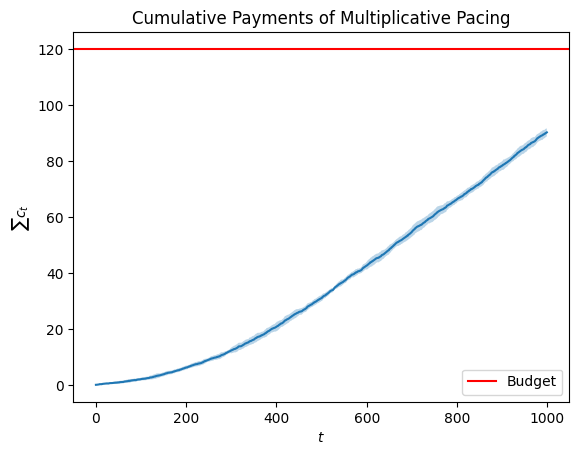

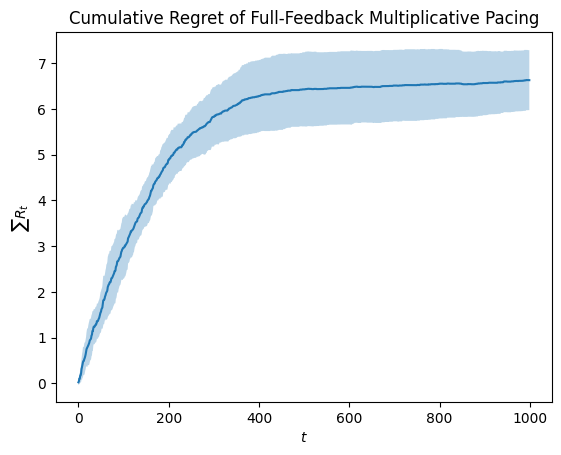

In [25]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

In [9]:
n_advertisers = 3
n_users = 1000
B = 120
my_valuation = 0.6
rho = B/n_users
eta = 1/np.sqrt(n_users)  #theorical learning rate to achieve sub linear regret
ctrs = np.ones(n_advertisers)



n_epochs = 10
all_regrets = []
all_payments = []
for i in range(n_epochs):
    agent = ucblike(B,n_users,1,my_valuation)

    auction = SecondPriceAuction(ctrs)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])
    other_bids = np.random.uniform(0, 1, size = (n_advertisers-1, n_users)) # n_advertiser-1 cause one is my agent, that i don't have to consider in other
    m_t = other_bids.max(axis=0)


    clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)   
    
    np.random.seed(i)
    for u in range(n_users):

        
        # interaction
        my_bid = agent.pull_arm()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t)
        # logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
        
    all_regrets.append(np.cumsum(clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis = 0)
std_regret  = np.array(all_regrets).std(axis = 0)


avg_payments = np.array(all_payments).mean(axis = 0)
std_payments = np.array(all_payments).std(axis = 0)

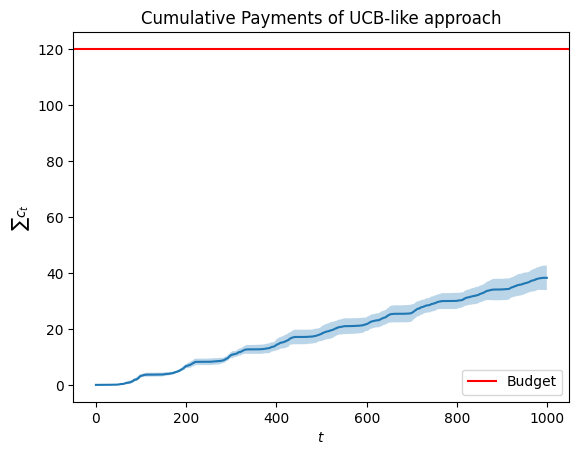

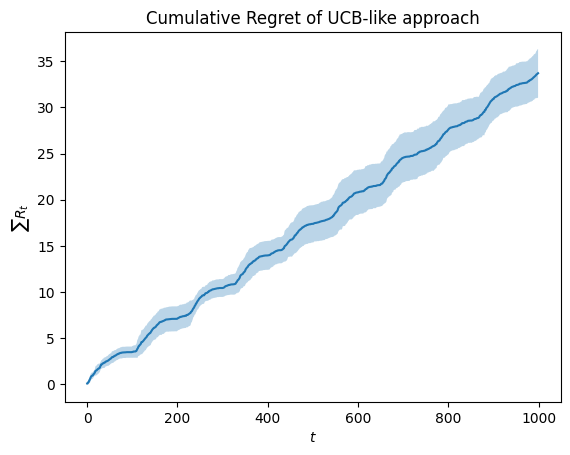

In [10]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of UCB-like approach')
plt.show()

plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of UCB-like approach')
plt.show()

WHAT ABOUT GPUCB?

In [15]:
n_advertisers = 3
n_users = 1000
B = 120
my_valuation = 0.6
rho = B/n_users
eta = 1/np.sqrt(n_users)  #theorical learning rate to achieve sub linear regret
ctrs = np.ones(n_advertisers)



n_epochs = 5
all_regrets = []
all_payments = []
for i in range(n_epochs):
    agent = gpucblike(B,n_users,1,my_valuation)

    auction = SecondPriceAuction(ctrs)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])
    other_bids = np.random.uniform(0, 1, size = (n_advertisers-1, n_users)) # n_advertiser-1 cause one is my agent, that i don't have to consider in other
    m_t = other_bids.max(axis=0)


    clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)   
    
    np.random.seed(i)
    for u in range(n_users):

        
        # interaction
        my_bid = agent.pull_arm()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t)
        # logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
        
    all_regrets.append(np.cumsum(clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis = 0)
std_regret  = np.array(all_regrets).std(axis = 0)


avg_payments = np.array(all_payments).mean(axis = 0)
std_payments = np.array(all_payments).std(axis = 0)

epoch number 0
epoch number 1
epoch number 2
epoch number 3
epoch number 4


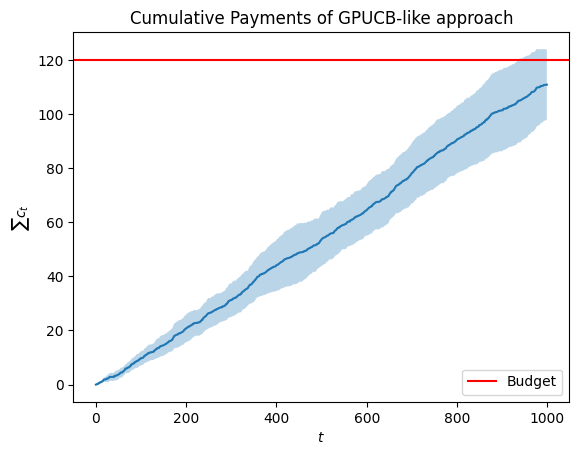

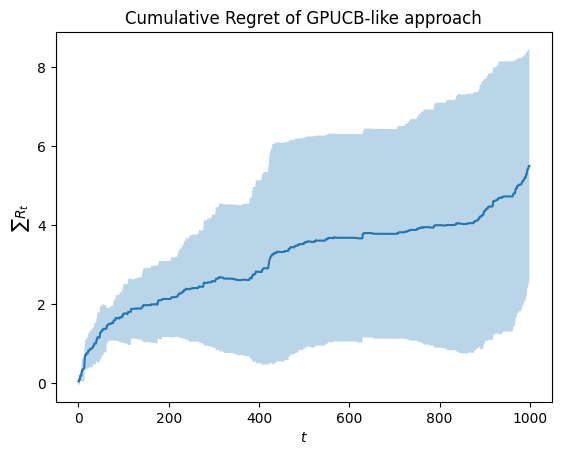

In [16]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of GPUCB-like approach')
plt.show()

plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of GPUCB-like approach')
plt.show()

Putting all pieces together

In [31]:
#parameters
days=1000
n_users = 1000
n_advertisers = 4 # four advertisers, including myself
ctrs = np.ones(n_advertisers)
B = 200000
my_valuation=best_price
#logging
profits=np.array([])
clair_profits=np.array([])
bids_won_log=np.zeros(days)
clair_bids_won=np.zeros(days)
pricing_profit=np.zeros(days)
expected_clair_pricing_profit=np.zeros(days)

# competitors
other_bids = np.random.uniform(0, 1, size = (n_advertisers-1, n_users*days)) 
m_t = other_bids.max(axis=0)
## I'm considering competitors stronger than me, since they are free to exceed my budget

# In stochastic enviroment a greedy clairvoyant 
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users*days)

eta = 1/np.sqrt(n_users) # from theory

#agents,envs
bidding_agent = MultiplicativePacingAgent(valuation=1,
                                  budget=B,
                                  T=n_users*days, 
                                  eta=eta)

auction = SecondPriceAuction(ctrs)
pricing_env=PricingEnvironment(norm_dem_curve,cost)
pricing_agent=GPUCBAgent(n_users*days)
expected_max_profit=get_expected_profit(norm_dem_curve,cost,np.linspace(0,1,100))

for d in range(days):
    #choose price
    price=pricing_agent.pull_arm()
    #bids won in the day
    bids_won=0
    #cost of the day
    tot_cost=0
    for u in range(n_users):
        #choose bid
        my_bid = bidding_agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        bids_won+=my_win
        tot_cost+=c_t
        #update bidding agent
        bidding_agent.update(f_t, c_t)
    bids_won_log[d]=bids_won
    
    #user buys with a probability that depends on the price
    if bids_won>0:
        d_t, r_t = pricing_env.round(price, bids_won)
        pricing_agent.update(r_t/bids_won)
    else: 
        r_t=0
    pricing_profit[d]=r_t
    profits=np.append(profits,r_t-tot_cost)
    #pseudo regret for pricing (considering bids won by my advertising campaign)
    expected_clair_pricing_profit[d]=bids_won*expected_max_profit
    #calculate clairvoyant profit
    clair_num_daily=clairvoyant_payments[d*n_users:(d+1)*n_users]
    clair_num=np.count_nonzero(clair_num_daily)
    cr,cd=pricing_env.round(best_price,clair_num)
    clair_cumpay=np.sum(clair_num_daily)
    clair_profits=np.append(clair_profits,cr-clair_cumpay)
    clair_bids_won[d]=clair_num

profits=np.cumsum(profits)
clair_profits=np.cumsum(clair_profits)
bids_won_log=np.cumsum(bids_won_log)
clair_bids_won=np.cumsum(clair_bids_won)
pricing_profit=np.cumsum(pricing_profit)
expected_clair_pricing_profit=np.cumsum(expected_clair_pricing_profit)


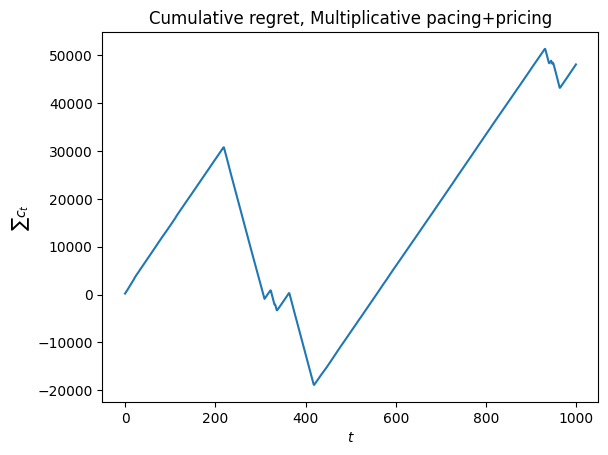

In [32]:
plt.plot(np.arange(days),clair_profits-profits)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.title('Cumulative regret, Multiplicative pacing+pricing')
plt.show()

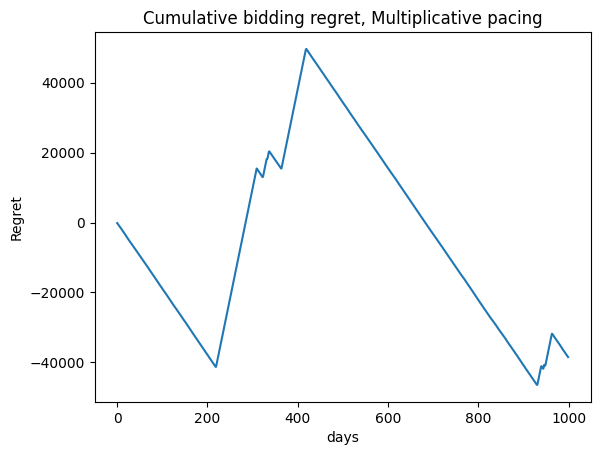

In [33]:
plt.plot(clair_bids_won-bids_won_log)
plt.xlabel('days')
plt.ylabel('Regret')
plt.title('Cumulative bidding regret, Multiplicative pacing')
plt.show()

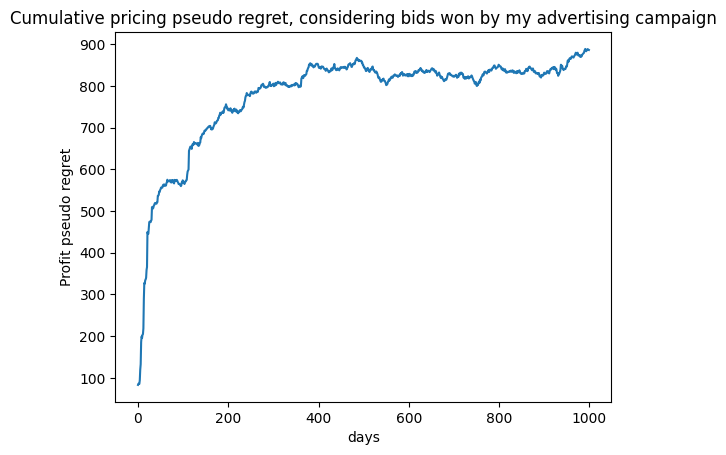

In [34]:
plt.plot(expected_clair_pricing_profit-pricing_profit)
plt.xlabel('days')
plt.ylabel('Profit pseudo regret')
plt.title('Cumulative pricing pseudo regret, considering bids won by my advertising campaign')
plt.show()

In [1]:
n_companies = 3
days = 10

bidding_agent=UCBlike_agent()
bidding_env=bidenv()
pricing_agent=GP_agent()
pricing_env=pricenv()
auction_env=auction(bidding_env, pricing_env)
for c in range(n_companies):
    for d in range(days):
        #choose price
        price=pricing_agent.ChoosePrice()

        #BIDDING
        bid = bidding_agent.ChooseBid(price)
        win_count = auction_env.round(bid)
        bidding_agent.update(bid,win_count)

        #PRICING
        d,r=auction_env.sell(price)
        pricing_agent.update(price,r/d)

SyntaxError: incomplete input (2836940658.py, line 16)

### This way we change bid value many times for the same price. Then each day we chamge the price p and we try with different prices